# ¡Atrapa ese asteroide con poliastro!

![NEOs](img/neos.png)

### Antonio Hidalgo & Juan Luis Cano

### 2017-07-23 PyConES 2017 @ Cáceres

1. Presentación (1 minutos)
2. Mecánica orbital (3 minutos)
3. poliastro (3 minutos)
4. Cuerpos cercanos (4 minutos)
5. Demo NEOS (7 minutos)
6. SOCIS y conclusiones (2 minutos)

## Presentación

### Juan Luis Cano (core, project author) + Antonio Hidalgo (new contributor!)

![Dev](img/dev.jpg)

## ¿Qué es la Mecánica Orbital?

### Física → Mecánica → Mecánica Celeste → Mecánica Orbital

> Una rama de la Mecánica (a su vez una rama de la Física) que estudia problemas prácticos acerca del movimiento de cohetes y otros vehículos en el espacio

### Pero ¿por qué los cuerpos orbitan?

Eso da para una charla entera :) Como resumen, visualicemos este experimento mental ideado por Newton:

<img src="img/newtons-cannonball.jpg" alt="Newton" width="400" ></img>

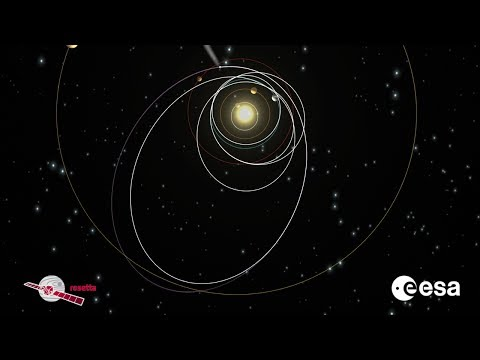

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("iEQuE5N3rwQ", width=800, height=600)

## poliastro

<img src="img/logo_text.svg" alt="poliastro" width="500" style="float:right"></img>

* **Python puro**, acelerado con **numba** (~mismo orden de magnitud que Fortran)
* **Licencia MIT** (permisiva)
* Manejo de unidades físicas y escalas temporales gracias a Astropy
* Conversión entre varias representaciones orbitales
* Propagación analítica y numérica
* Documentación molona 🚀 http://docs.poliastro.space/
* ¡Versión 0.7.0 liberada hace una semana! http://blog.poliastro.space/2017/09/15/2017-09-15-poliastro-070-released-ready-pycones/

<div style="clear:both"></div>

In [2]:
import matplotlib.pyplot as plt
plt.ion()

from astropy import units as u
from astropy.time import Time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.plotting import plot, OrbitPlotter

## _Interlude: Time zones? Hold my beer_

![Escalas temporales](time_scales.png)

In [3]:
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v, Time.now())
ss

7283 x 10293 km x 153.2 deg orbit around Earth (♁)

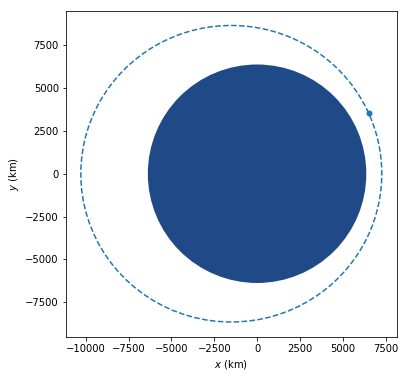

In [4]:
plot(ss);

## Cuerpos cercanos

También conocidos como NEOs, del inglés Near Earth Objetcs.

> Son cometas y asteroides a los que las  fuerzas gravitatorias del Sistema Solar han atraído a las cercanías de la Tierra.

Existen más de 16000.

### Tipos de NEOs

.

![tipos de neos](img/neo_orbit_types.jpg)

### ¿Por qué NEOs?

* Aplicaciones en investigación científica.

![Mining the Sky](img/mining_the_sky.jpg)

* Riesgo de impacto contra la Tierra.

![impactos sobre la Tierra](img/bolide_events.jpg)

## poliastro y su paquete NEOS

Como parte del proyecto SOCIS, se ha añadido en la versión 0.7 de poliastro un paquete NEOS. Está dividido en dos módulos:

In [5]:
from poliastro.neos import neows, dastcom5

## Módulo NEOWS

El módulo se basa en [este Servicio Web de la NASA](https://api.nasa.gov/api.html#NeoWS).

![Interfaz web NEOWS](interfaz_neows.png)

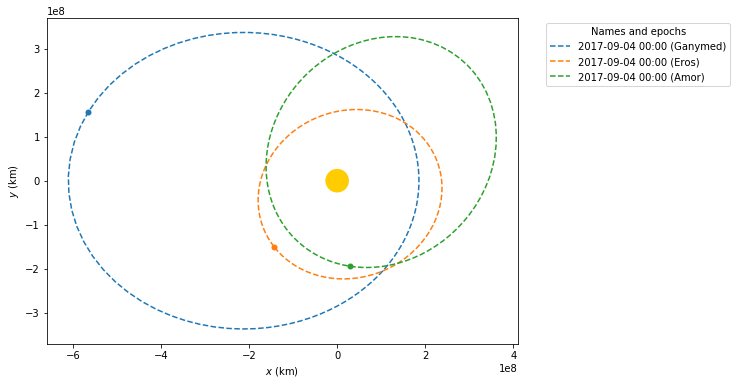

In [6]:
eros = neows.orbit_from_name('Eros')
ganymed = neows.orbit_from_name('1036') # Ganymed IAU number
amor = neows.orbit_from_name('2001221') # Amor SPK-ID

frame = OrbitPlotter(num_points=300)
frame.plot(ganymed, label='Ganymed')
frame.plot(eros, label='Eros')
frame.plot(amor, label='Amor')

## ¿Cómo funciona?

![SBDB](img/sbdb.png)

## Módulo DASTCOM5

Trabaja con la base de datos DASTCOM5, mantenida por la NASA y el JPL. Contiene datos sobre cometas y asteroides.

La base de datos viene en un zip de unos ~230 MB que se puede descargar [a mano](ftp://ssd.jpl.nasa.gov/pub/ssd/dastcom5.zip) y descomprimir en `~/.poliastro`, o, más fácil, se puede usar una función de poliastro:

```python
dastcom5.download_dastcom5()
```

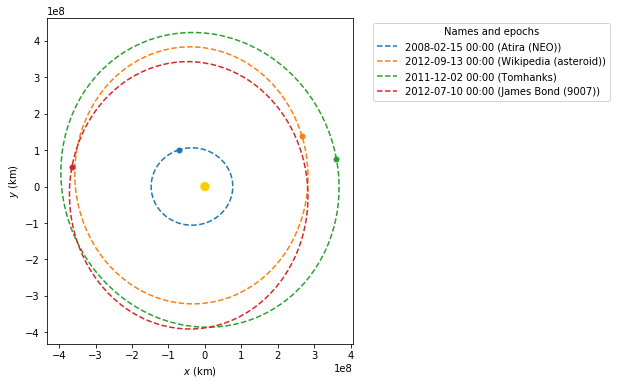

In [8]:
atira = dastcom5.orbit_from_name('atira')[0] # NEO
wikipedia = dastcom5.orbit_from_name('wikipedia')[0] # Asteroid, but not NEO.
tomhanks = dastcom5.orbit_from_name('tomhanks')[0]
jamesbond = dastcom5.orbit_from_name('9007')[0]

frame = OrbitPlotter()
frame.plot(atira, label='Atira (NEO)')
frame.plot(wikipedia, label='Wikipedia (asteroid)')
frame.plot(tomhanks, label='Tomhanks')
frame.plot(jamesbond, label='James Bond (9007)');

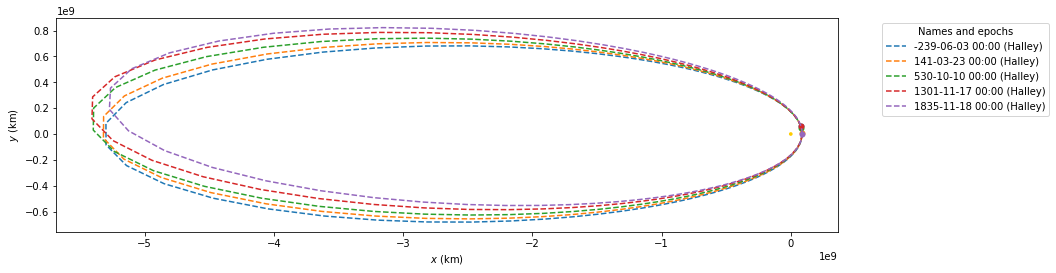

In [54]:
halleys = dastcom5.orbit_from_name('1P')

frame = OrbitPlotter(num_points=200)
frame.plot(halleys[0], label='Halley')
frame.plot(halleys[5], label='Halley')
frame.plot(halleys[10], label='Halley')
frame.plot(halleys[20], label='Halley')
frame.plot(halleys[30], label='Halley')

## ¿Cómo funciona?

![dastcom5 index](img/dastcom5_index.png)

![DASTCOM5 structure](img/dastcom5_structure.png)

![Asteroid and comet structure](img/ast_com_structure.png)

In [55]:
ast_db = dastcom5.asteroid_db()
comet_db = dastcom5.comet_db()

ast_db.dtype.names[:20] # They are more than 100, but that would be too much lines in this notebook :P

('NO',
 'NOBS',
 'OBSFRST',
 'OBSLAST',
 'EPOCH',
 'CALEPO',
 'MA',
 'W',
 'OM',
 'IN',
 'EC',
 'A',
 'QR',
 'TP',
 'TPCAL',
 'TPFRAC',
 'SOLDAT',
 'SRC1',
 'SRC2',
 'SRC3')

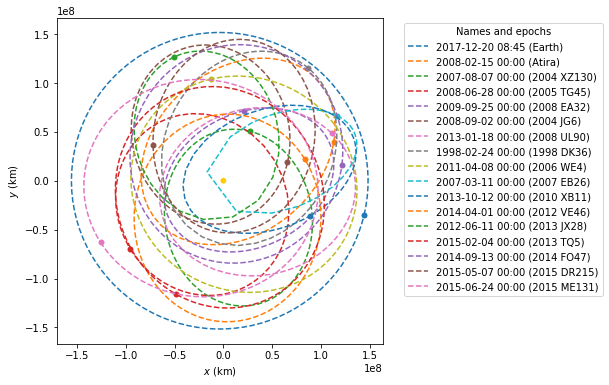

In [56]:
aphelion_condition = 2 * ast_db['A'] - ast_db['QR'] < 0.983
axis_condition = ast_db['A'] < 1.3 
atiras = ast_db[aphelion_condition & axis_condition]

earth = Orbit.from_body_ephem(Earth)

frame = OrbitPlotter()
frame.plot(earth, label='Earth')

for i in range(len(atiras)):
    record = atiras['NO'][i]
    label = atiras['ASTNAM'][i].decode().strip()  # DASTCOM5 strings are binary
    ss = dastcom5.orbit_from_record(record)
    frame.plot(ss, label=label)

In [57]:
db = dastcom5.entire_db()

db[db.NAME == 'Churyumov-Gerasimenko']

,NUMBER,NOBS,OBSFRST,OBSLAST,EPOCH,CALEPOCH,MA,W,OM,IN,EC,A,QR,TP,TPCAL,TPFRAC,SOLDAT,DESIG,IREF,NAME
740310,900667,1154,0,0,2440480.5,19690916.0,0.746918,11.246300,51.011000,7.149400,0.633017,3.501429,1.284965,2.440476e+06,1.969091e+07,0.534800,0.000000e+00,67P,SAO/1969,Churyumov-Gerasimenko
740311,900668,1154,0,0,2442880.5,19760412.0,0.713185,11.358700,51.028400,7.128900,0.630558,3.514828,1.298525,2.442876e+06,1.976041e+07,0.731800,0.000000e+00,67P,SAO/1976,Churyumov-Gerasimenko
740312,900669,1154,0,0,2445280.5,19821107.0,359.239635,11.366700,51.015300,7.117000,0.629152,3.522047,1.306144,2.445286e+06,1.982111e+07,0.599300,0.000000e+00,67P,SAO/1982,Churyumov-Gerasimenko
740313,900670,1154,0,0,2447680.5,19890603.0,357.698070,11.424500,51.011500,7.118300,0.630254,3.515073,1.299684,2.447696e+06,1.989062e+07,0.891800,0.000000e+00,67P,SAO/1989,Churyumov-Gerasimenko
740314,900671,1154,0,0,2450080.5,19951229.0,357.060788,11.386100,51.007000,7.113500,0.630193,3.515434,1.300032,2.450100e+06,1.996012e+07,0.156000,0.000000e+00,67P,SAO/1996,Churyumov-Gerasimenko
740315,900672,1154,0,0,2452520.5,20020903.0,2.354453,11.451400,50.969300,7.120500,0.631529,3.507299,1.292338,2.452505e+06,2.002082e+07,0.809200,0.000000e+00,67P,SAO/2002,Churyumov-Gerasimenko
740316,900673,6325,19950703,20170427,2455491.5,20101022.0,91.768086,12.694464,50.180046,7.043681,0.640582,3.464738,1.245288,2.454891e+06,2.009023e+07,0.027525,2.457882e+06,67P,K154/1,Churyumov-Gerasimenko


## SOCIS y conclusiones

* Sin una persona a tiempo completo, este proyecto no habría llegado hasta aquí
* Sin dinero, no puede haber personas a tiempo completo :)
* Este programa no se conoce mucho en España, ¡ayudadnos a difundir!

# _Per Python ad astra!_

* Diapositivas: https://github.com/poliastro/pycones2017-talk
* Chat: https://riot.im/app/#/room/#poliastro:matrix.org

## Muchas gracias :)

![Rocket](img/rocket.jpg)